In [1]:
# notebooks/02_BaselinePipeline.ipynb
# Runs end-to-end baseline pipeline for ERA5 precipitation prediction

# LOAD LIBRARIES

In [1]:
# Load libraries
import sys
from pathlib import Path
sys.path.append(str(Path("../").resolve()))

from src.train import train_baseline_models, print_results
from src.evaluate import evaluate_predictions, evaluate_extreme_events
from src.baseline_models import create_history_windows
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# SET UP DATA PATH & PARAMETERS

In [2]:
# Load data and set up window length for training
processed_folder = "../data"
data_path = f"{processed_folder}/era5_1960to2020_17feats_processed.npz"
print(data_path)

T = 7          # NUMBER OF DAYS USED AS HISTORY
horizon = 3    # SINGLE-STEP DAILY PRECIPITATION PREDICTION
p_window = 7   # NUMBER OF DAYS USED FOR PERSISTENCE MODEL AVERAGE

../data/era5_1960to2020_17feats_processed.npz


# TRAIN BASELINE MODELS

In [3]:
# Train baseline models
results = train_baseline_models(data_path, T=T, horizon=horizon, p_window=p_window)
print_results(results)

Test Data Results:
------------------
CLIMATOLOGY --> RMSE = 7.940743923187256, MAE = 4.696826934814453
PERSISTENCE --> RMSE = 8.434200286865234, MAE = 5.217033386230469
LINEAR REGRESSION --> RMSE = 7.912927150726318, MAE = 4.725957870483398


# EVALUATE MODEL PREDICTIONS

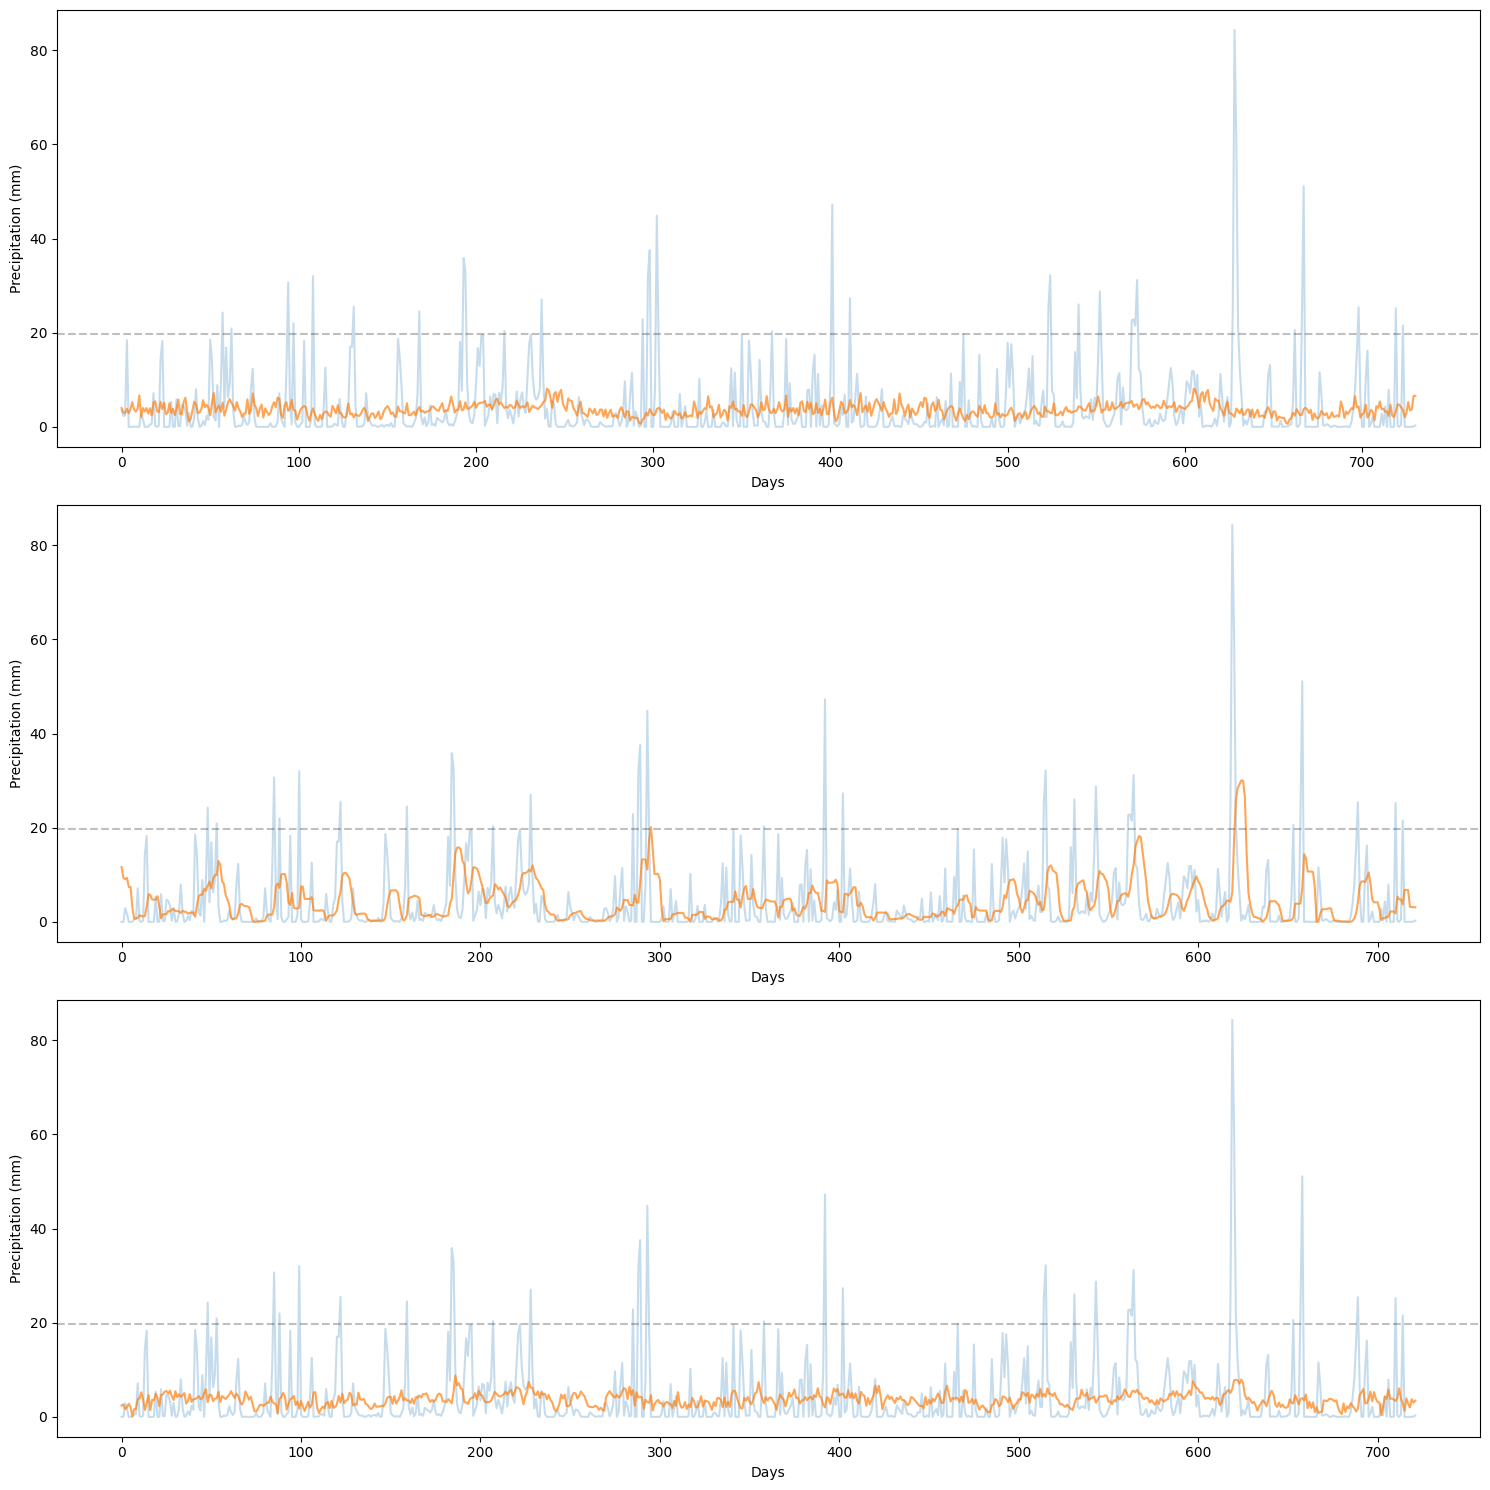

In [4]:
# Plot testing predictions vs. true test data
y_true = np.load(data_path)['y_test']
threshold = np.percentile(y_true, 95)

plt.figure(figsize=(15,15))

for i, model in enumerate(results.keys()):
    plt.subplot(3, 1, i+1)
    
    y_pred = results[model]['y_pred']
    
    if model in ['linear_regression', 'persistence']:
        y_true_aligned = y_true[T-1 + horizon : T-1 + horizon + len(y_pred)]
    else:
        y_true_aligned = y_true[:len(y_pred)]
    
    plt.plot(y_true_aligned, label='Observed', alpha=0.25)
    plt.plot(y_pred, label='Predicted', alpha=0.7)
    plt.axhline(y=threshold, color='black', linestyle='--', label='95th Percentile', alpha=0.25)
    
    # plt.title(f"{model.title()} Model Predictions")
    plt.xlabel("Days")
    plt.ylabel("Precipitation (mm)")
    # plt.legend()

plt.tight_layout()
plt.show()

# EVALUATE EXTREME EVENTS (>95TH PERCENTILE)

In [5]:
# Evaluate on extreme events
for model_name, result in results.items():
    y_pred = result['y_pred']
    model_display = model_name.replace("_", " ").upper()
    print(f"\nEvaluating extreme events for {model_display} model:")
    evaluate_extreme_events(y_true, y_pred, percentile=95)
    print("-"*50)


Evaluating extreme events for CLIMATOLOGY model:
Extreme events > 95th percentile -> RMSE: 29.418415069580078, MAE: 26.410179138183594
Total extreme events: 37, Predicted extreme events: 0
--------------------------------------------------

Evaluating extreme events for PERSISTENCE model:
Extreme events > 95th percentile -> RMSE: 29.015710830688477, MAE: 25.428022384643555
Total extreme events: 37, Predicted extreme events: 0
--------------------------------------------------

Evaluating extreme events for LINEAR REGRESSION model:
Extreme events > 95th percentile -> RMSE: 29.64645767211914, MAE: 26.606746673583984
Total extreme events: 37, Predicted extreme events: 0
--------------------------------------------------


---

- *Linear Regression outperforms climatology and persistance model could indicate linear regression is capturing some of the features in the data*
- *Persistance model is a 7 day average and is the worst performer*
- *All three baseline models fail to predict any of the extreme precipitation events which indicates all models severly underestimate days with large amounts of precipitation* 

# MULTIPLE HORIZON EVALUATION

In [6]:
# Train on multiple horizon windows
# Number of days in the future to predict
T = 7
horizons = [1, 2, 3, 4, 5, 6, 7]
results_horizon = {}

for h in horizons:
    print(f"\nEvaluation for horizon t+{h}\n")
    results = train_baseline_models(data_path, T=T, horizon=h)
    print_results(results)
    print("--------------------------------")

    horizon_metrics = {}
    for model_name, result in results.items():
        rmse = result['rmse']
        mae = result['mae']
        horizon_metrics[model_name] = {"rmse":rmse, "mae":mae}
    results_horizon[h] = horizon_metrics


Evaluation for horizon t+1

Test Data Results:
------------------
CLIMATOLOGY --> RMSE = 7.940743923187256, MAE = 4.696826934814453
PERSISTENCE --> RMSE = 8.42258071899414, MAE = 5.2026214599609375
LINEAR REGRESSION --> RMSE = 6.450606346130371, MAE = 4.066104888916016
--------------------------------

Evaluation for horizon t+2

Test Data Results:
------------------
CLIMATOLOGY --> RMSE = 7.940743923187256, MAE = 4.696826934814453
PERSISTENCE --> RMSE = 8.428132057189941, MAE = 5.209817409515381
LINEAR REGRESSION --> RMSE = 7.62501335144043, MAE = 4.614211082458496
--------------------------------

Evaluation for horizon t+3

Test Data Results:
------------------
CLIMATOLOGY --> RMSE = 7.940743923187256, MAE = 4.696826934814453
PERSISTENCE --> RMSE = 8.434200286865234, MAE = 5.217033386230469
LINEAR REGRESSION --> RMSE = 7.912927150726318, MAE = 4.725957870483398
--------------------------------

Evaluation for horizon t+4

Test Data Results:
------------------
CLIMATOLOGY --> RMSE =

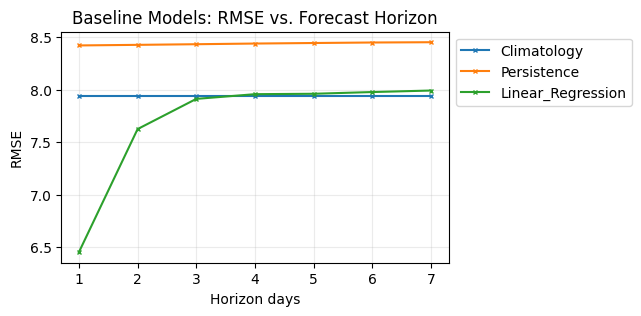

In [7]:
# Plot results at each horizon
plt.figure(figsize=(5,3))
for model_name in results_horizon[1].keys():
    rmse_scores = [results_horizon[h][model_name]['rmse'] for h in horizons]
    plt.plot(horizons, rmse_scores, marker='x', label=model_name.title(), markersize=3)

plt.xlabel("Horizon days")
plt.ylabel("RMSE")
plt.title("Baseline Models: RMSE vs. Forecast Horizon")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, alpha=0.25)
plt.show()

# HISTORY WINDOW EVALUATION

In [8]:
# Train on multiple training windows
# 3 days of history vs. 56 days of history
T = [3, 7, 14, 21, 28, 35, 42, 49, 56]
horizon = 7
results_window = {}

for day in T:
    print(f"\nEvaluation for history window: {day} days\n")
    results = train_baseline_models(data_path, T=day, horizon=horizon)
    print_results(results)
    print("--------------------------------")

    window_metrics = {}
    for model_name, result in results.items():
        rmse = result['rmse']
        mae = result['mae']
        window_metrics[model_name] = {"rmse":rmse, "mae":mae}
    results_window[day] = window_metrics


Evaluation for history window: 3 days

Test Data Results:
------------------
CLIMATOLOGY --> RMSE = 7.940743923187256, MAE = 4.696826934814453
PERSISTENCE --> RMSE = 8.434200286865234, MAE = 5.217033386230469
LINEAR REGRESSION --> RMSE = 7.94658899307251, MAE = 4.7580342292785645
--------------------------------

Evaluation for history window: 7 days

Test Data Results:
------------------
CLIMATOLOGY --> RMSE = 7.940743923187256, MAE = 4.696826934814453
PERSISTENCE --> RMSE = 8.453216552734375, MAE = 5.22912073135376
LINEAR REGRESSION --> RMSE = 7.992520332336426, MAE = 4.742254257202148
--------------------------------

Evaluation for history window: 14 days

Test Data Results:
------------------
CLIMATOLOGY --> RMSE = 7.940743923187256, MAE = 4.696826934814453
PERSISTENCE --> RMSE = 8.469496726989746, MAE = 5.2361040115356445
LINEAR REGRESSION --> RMSE = 8.084661483764648, MAE = 4.855991363525391
--------------------------------

Evaluation for history window: 21 days

Test Data Res

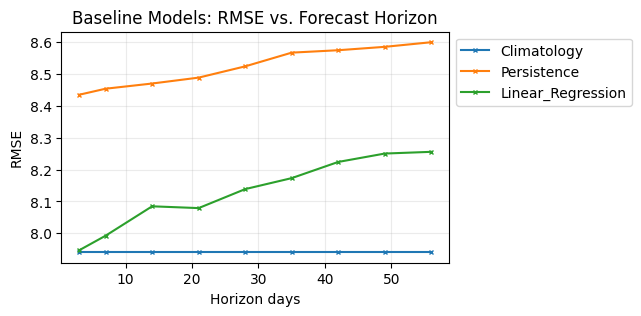

In [9]:
# View results from training
plt.figure(figsize=(5,3))
for model_name in results_window[7].keys():
    rmse_scores = [results_window[day][model_name]['rmse'] for day in T]
    plt.plot(T, rmse_scores, marker='x', label=model_name.title(), markersize=3)

plt.xlabel("Horizon days")
plt.ylabel("RMSE")
plt.title("Baseline Models: RMSE vs. Forecast Horizon")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, alpha=0.25)
plt.show()